### Milestone 1: Getting to know your data, due Wednesday, April 5, 2017

#### Eric Abreu, Anmol Gupta, Sam Plank, Mirai Shah

In the beginning you should get acquainted with the data sources and do some EDA. Sign up for the TMDb [API](https://www.themoviedb.org/documentation/api), and try to download the poster of your favorite movie from within your notebook. Compare the genre entries of IMDb and TMDb for this movie and see if they are the same. Think about and write down some questions that you would like to answer in the following weeks. Keep the storytelling aspect of your final report in mind and do some pen and paper sketches about the visualizations you would like to produce. Include photographs of those sketches in your notebook. 

Most of the time a data scientist spends on a project is spent on cleaning the data. We are lucky that the data we have is already pretty clean. The Python interface to the IMDb ftp files does a lot of the additional work of cleaning as well. However, you will notice that the genre list for each movie from both databases can have different lengths. This needs to be changed in order to train a model to predict the movie genre. It is up to you to think about possible ways to address this problem and to implement one of them. There is no absolute right answer here. It depends on your interests and which questions you have in mind for the project. 

Optionally, you could also scrape additional data sources, such as Wikipedia, to obtain plot summaries. That data may give you additional useful features for genre classification. 

To guide your decision process, provide at least one visualization of how often genres are mentioned together in pairs. Your visualization should clearly show if a horror romance is more likely to occur in the data than a drama romance.

The notebook to submit for this milestone needs to at least include:

- API code to access the genre and movie poster path of your favorite movie
- Genre for this movie listed by TMDb and IMDb
- A list of the 10 most popular movies of 2016 from TMDb and their genre obtained via the API
- Comments on what challenges you see for predicting movie genre based on the data you have, and how to address them 
- Code to generate the movie genre pairs and a suitable visualization of the result
- Additional visualization sketches and EDA with a focus on movie genres
- A list of questions you could answer with this and related data. Get creative here!

The EDA questions do not necessarily have to tie into the modeling part later on. Think freely about things that might be interesting, like which actors are very specific to a genre? Are action movies more prone to producing sequels than romances? However, as you keep the focus on movie genres, think also about correlations you might discover that can help build features from the metadata for prediction. Is the length of a movie title correlated with genre?


In [46]:
from IPython.display import HTML
import numpy as np
import pandas as pd
import tmdbsimple as tmdb
import json, urllib
import time
import pandas as pd
import os.path
from PIL import Image
from StringIO import StringIO
from tmdb3 import  Movie, Genre, searchMovie, set_key, Movie, Genre
import ggplot
from ggplot import *
import matplotlib
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imdb import IMDb
from IPython.display import display, HTML
%matplotlib inline

##### 1. API code to access genre and movie poster path of favorite movie

Title: Inside Out


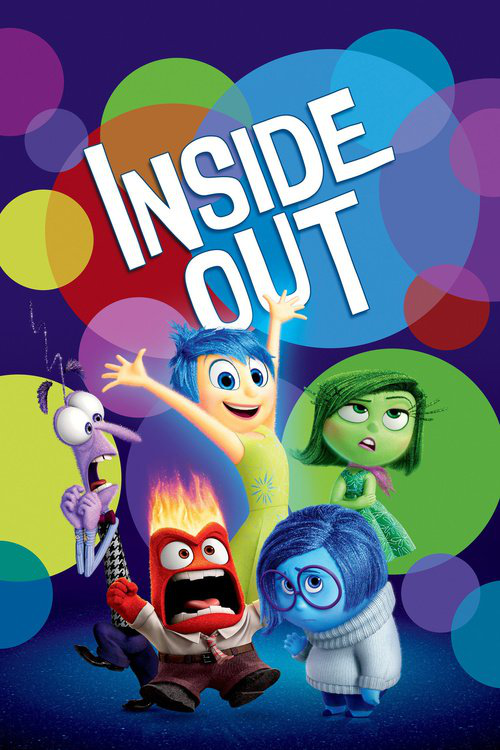

In [24]:
# Setup movie libraries
set_key('98ca260f92ac9b42606914b232546089')
tmdb.API_KEY = '98ca260f92ac9b42606914b232546089'
imdb = IMDb()

# Converts a Genre object to a string
def genre_to_str(genres):
    return ', '.join([x.name for x in genres])

# Get title from the search result
movie = searchMovie('Inside Out')[0]
print "Title: " + movie.title

# Get movie poster
poster = urllib.urlopen(movie.poster.geturl('w500'))
Image.open(StringIO(poster.read()))

##### 2. Genre for "Inside Out" by TMDb and IMDb

In [26]:
# Get genre info from TMDb
print "TMDb"
print "----"
print "Title: " + movie.title 
print "Genres: " + genre_to_str(movie.genres)

# Get genre info from IMDb
print "\nIMDb"
print "----"
movie_imdb = imdb.get_movie(imdb.search_movie('Inside Out')[0].movieID)
print "Title: " + movie_imdb['title']
print "Genres: " + ", ".join(movie_imdb['genre'])

TMDb
----
Title: Inside Out
Genres: Comedy, Animation, Family

IMDb
----
Title: Inside Out
Genres: Animation, Adventure, Comedy, Drama, Family, Fantasy


##### 3. A list of the 10 most popular movies of 2016 from TMDb and their genre obtained via the API

In [27]:
# Get the 10 most popular movies of 2016
discover = tmdb.Discover()
results = discover.movie(year=2016, sort_by='popularity.desc')['results'][:10]
movies = [Movie(r['id']) for r in results]
titles = [m.title for m in movies]; genres = [genre_to_str(m.genres) for m in movies]

# Build a title/genre table
popular_df = pd.DataFrame({"Title": titles, "Genres": genres}, index=range(1, len(titles) + 1))
popular_df = popular_df[["Title", "Genres"]]
popular_df

,Title,Genres
1,Sing,"Animation, Comedy, Drama, Family, Music"
2,Fantastic Beasts and Where to Find Them,"Adventure, Action, Fantasy"
3,Split,"Horror, Thriller"
4,Finding Dory,"Adventure, Animation, Comedy, Family"
5,Deadpool,"Action, Adventure, Comedy, Romance"
6,Rogue One: A Star Wars Story,"Action, Drama, Science Fiction, War"
7,Doctor Strange,"Action, Adventure, Fantasy, Science Fiction"
8,Arrival,"Drama, Science Fiction"
9,Captain America: Civil War,"Action, Science Fiction"
10,John Wick,"Action, Thriller"


##### 4. Comments on what challenges we see for predicting movie genre based on the data we have, and how to address them

Although all of the genres in the TMDb result are in the set of genres obtained from the IMDb library, the IMDb list has twice as many elements, which could potentially make it harder for us to predict movie genres based on the other data we have. In addition, it seems that TMDb lists the genres by how predominant they are in a given movie, but IMDb lists them in alphabetical order, so it will possibly be difficult to simplify the IMDb genre list later. Either way, both sources have multiple genres for any given movie, which should make it significantly harder to train our future models, as there is no clear-cut response variable that we are predicting. 

We also have dozens of predictors in each database and some of those fields have thousands of possible values (e.g., actors and directors) and will need to be able to deal with this high dimensionality when training our model. PCA and the clustering methods covered in class should help us address this issue. 

It also seems to be difficult to obtain large lists of movies using the IMDbPY library. It does have a `get_top250_movies()` function, but it is very slow, only returns the title, year, and average rating, and is impossible to customize. We tried to build a genre list for the top 250 movies, but it was taking an average of 5 seconds to get the genre list for a single movie. Thus, we will only be using TMDb and the IMDb database from Kaggle for this milestone. We are aware of some of the limitations of the Kaggle dataset, particularly the fact that it is biased to the more popular movies and thus might not have sufficient data about all the genres. 

##### 5. Code to generate the movie genre pairs and a suitable visualization of the result

In [37]:
if os.path.isfile('fullresults.json'):
    with open('fullresults.json', 'r') as fp:
        full_results = json.load(fp)
else:
    #get a list of genres
    genres = urllib.urlopen("https://api.themoviedb.org/3/genre/movie/list?" + "api_key=552fcccf23e3d49e5ccc3ed20c15bea2&language=en-US")
    read_genres = json.loads(genres.read())['genres']

    tmdb.API_KEY = "552fcccf23e3d49e5ccc3ed20c15bea2"
    full_results = {}
    discover = tmdb.Discover()
    genre = tmdb.Genres()

    #get top 500 movies for each genres
    for gen in read_genres:
        genre = tmdb.Genres(id=gen['id'])
        time.sleep(10)
        gen_results = []
        for i in range(1,26):
            #this is where you need to iterate through genres
            results = genre.movies(page=i)['results']
            gen_results += results
        full_results[gen['name']] = gen_results

    with open('fullresults.json', 'w') as fp:
        json.dump(full_results, fp)

In [39]:
#make an id-genre lookup 
genres = urllib.urlopen("https://api.themoviedb.org/3/genre/movie/list?api_key=552fcccf23e3d49e5ccc3ed20c15bea2&language=en-US")
read_genres = json.loads(genres.read())

genre_key = {}
for genre in read_genres['genres']:
    genre_key[genre['id']] = genre['name']

In [40]:
#count how many of each other genre show up in movies tagged as a specific genre
full_counts = {}
for genre in full_results.keys():

    full_counts[genre] = {}

    for each in full_results.keys():
        full_counts[genre][each] = 0.0

    for movies in full_results[genre]:

        genre_list = movies['genre_ids']

        #count secondary genres for each movie
        for each in genre_list:
            try:
                full_counts[genre][genre_key[each]] += 1.0
            except:
                pass
    
    for each in full_results.keys():
        full_counts[genre][each] = full_counts[genre][each] / 500.0


In [41]:
print(full_results['Mystery'][1])
print(full_results['Adventure'][1])
print(full_results['Family'][1])

{u'poster_path': u'/qmDpIHrmpJINaRKAfWQfftjCdyi.jpg', u'title': u'Inception', u'overview': u'Cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: "inception", the implantation of another person\'s idea into a target\'s subconscious.', u'release_date': u'2010-07-14', u'popularity': 9.043461, u'original_title': u'Inception', u'id': 27205, u'vote_count': 11142, u'video': False, u'adult': False, u'vote_average': 8.0, u'original_language': u'en', u'backdrop_path': u'/s2bT29y0ngXxxu2IA8AOzzXTRhd.jpg', u'genre_ids': [28, 53, 878, 9648, 12]}
{u'poster_path': u'/jjBgi2r5cRt36xF6iNUEhzscEcb.jpg', u'title': u'Jurassic World', u'overview': u'Twenty-two years after the events of Jurassic Park, Isla Nublar now features a fully functioning dinosaur theme park, Jurassic World, as originally envisioned by John Hammond.', u'release_date': u'2015-06-09', u'popular

In [42]:
df = pd.DataFrame(full_counts)

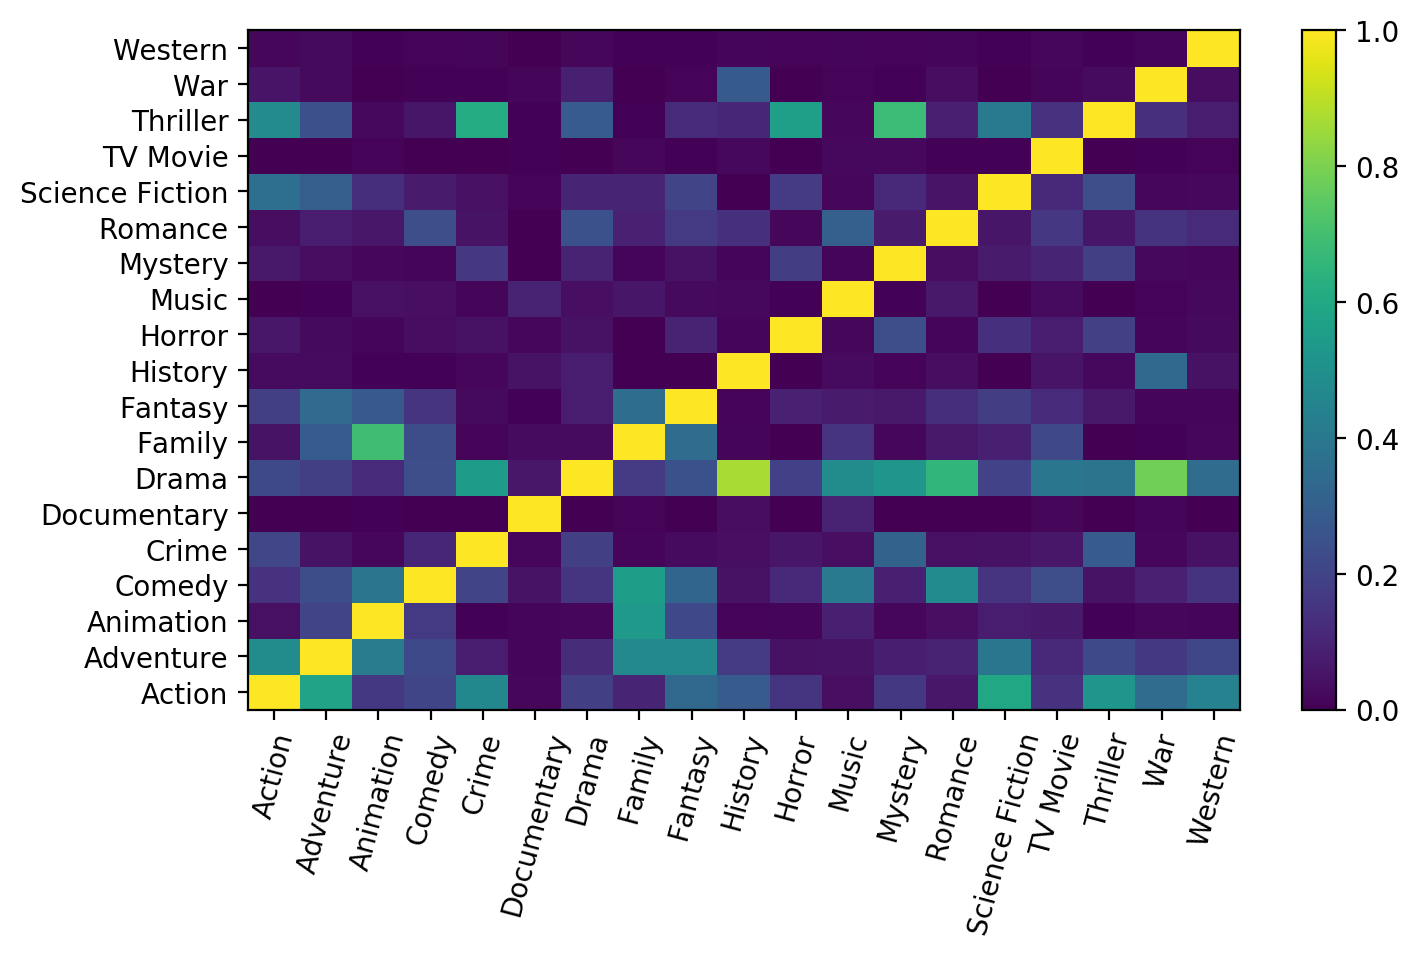

In [43]:
plt.subplots(figsize=(8, 4.5), dpi=200)
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=75)
plt.colorbar()
plt.show()

##### 6. Additional visualization sketches and EDA with a focus on movie genres

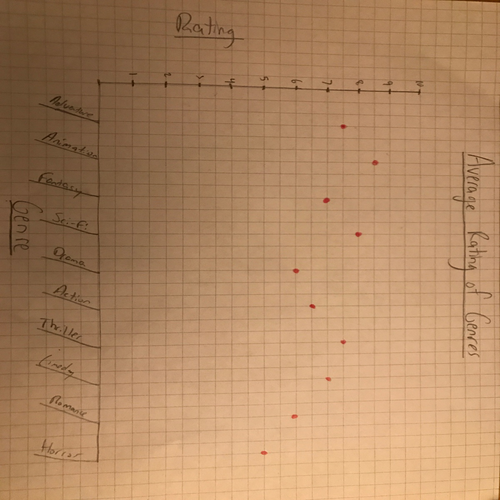

In [82]:
# sketch 1
img1 = Image.open('IMG_5931.jpg')
img1 = img1.resize((500,500), Image.ANTIALIAS)
display(img1)

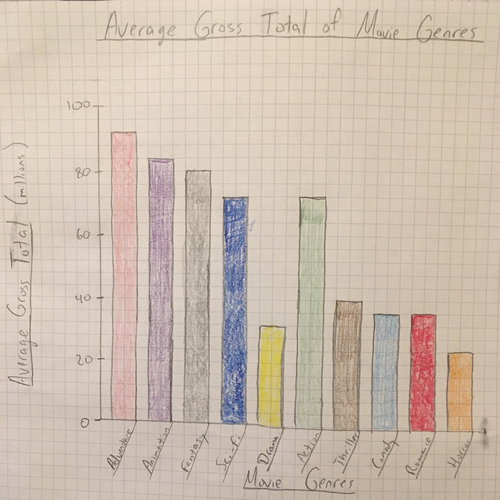

In [84]:
# sketch 2
img2 = Image.open('IMG_5932.jpg')
img2 = img2.resize((500,500), Image.ANTIALIAS)
display(img2)

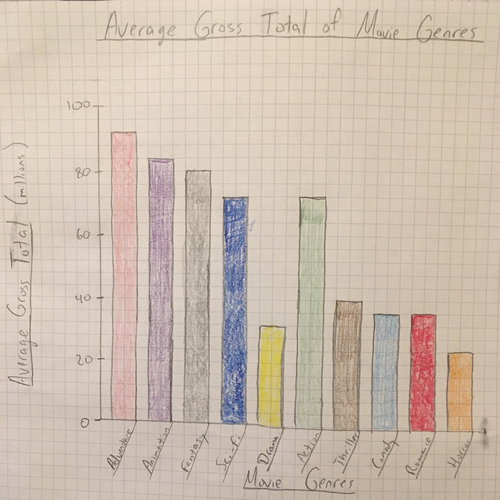

In [85]:
# sketch 3
img3 = Image.open('IMG_5932.jpg')
img3 = img3.resize((500,500), Image.ANTIALIAS)
display(img3)

The graphs shown above were created based on our own predictions of prior movie knowledge, and general internet surfing (links to relevant articles are below). For the Percentage of Genres of Movies, the breakdown was created mostly based on our own observations of common types of movies. Drama and Comedy movies seem to be the most prevalent, while action, adventure, and thriller movies some times tend to be similar in audience viewership, resulting in similar percentages. Horror and romantic comedy movies are shown to be much smaller than the rest because they tend to earn less money than other genres and tend to have similar plots from the movies within those two categories. 

Source:
https://introfilmgenres.wordpress.com/2014/10/08/genre-ratings-vs-gross-to-budget-ratio-nick-rittenhouse/


For the Average Gross Total, this is the averages of the profits per year from 2000-2014. As a result, the numbers that you see are the average total profits for 1 year for the genres. We see that action, adventure, animation, sci-fi, and fantasy top the list. This may be because there is more money required to make these films and they appeal to the public due to special effects, etc. resulting in greater viewership. 

Source:
http://www3.cs.stonybrook.edu/~skiena/591/final_projects/movie_gross/

Finally, for the average ratings, we see that they are all relatively the same. After viewing multiple sources, this was the common trend. This was interesting to see because that shows that critics are quite unbiased with their rating methods. Also, this shows that any type of movie can be “successful”, and that there isn’t one type that is superior to another in this category.

Source:
https://stephenfollows.com/how-good-are-movies-passing-bechdel-test/
https://vxcompany.com/2015/02/24/lets-take-big-data-to-the-movies/

Some additional sketches that we brainstormed and hope to delve deeper into in future milestones include examining which words are most common with each genre as well as which actors and directors are found most commonly with each genre. Additionally, we hope to look at the movie trends in the past century, particularly how the popularity of some genres might have gone up recently while other genres may no longer be as watched.

Below, we produced numerous visualizations, some which mirror the sketches above.

In [61]:
# read in Kaggle dataset for EDA
imdb_df = pd.read_csv('movie_metadata.csv', delimiter=',').dropna()

In [62]:
# merge all the genres for each movie into one list
all_genres = itertools.chain(imdb_df['genres'])
all_genres = list(all_genres)
merged = []

for element in all_genres:
    words = element.split('|')
    for word in words:
        merged.append(word)

In [63]:
# counts for each genre in Kaggle dataset
counts = Counter(merged)
counts

Counter({'Action': 959,
         'Adventure': 781,
         'Animation': 196,
         'Biography': 239,
         'Comedy': 1461,
         'Crime': 709,
         'Documentary': 45,
         'Drama': 1893,
         'Family': 442,
         'Fantasy': 507,
         'Film-Noir': 1,
         'History': 149,
         'Horror': 392,
         'Music': 151,
         'Musical': 96,
         'Mystery': 384,
         'Romance': 859,
         'Sci-Fi': 496,
         'Sport': 148,
         'Thriller': 1117,
         'War': 152,
         'Western': 59})

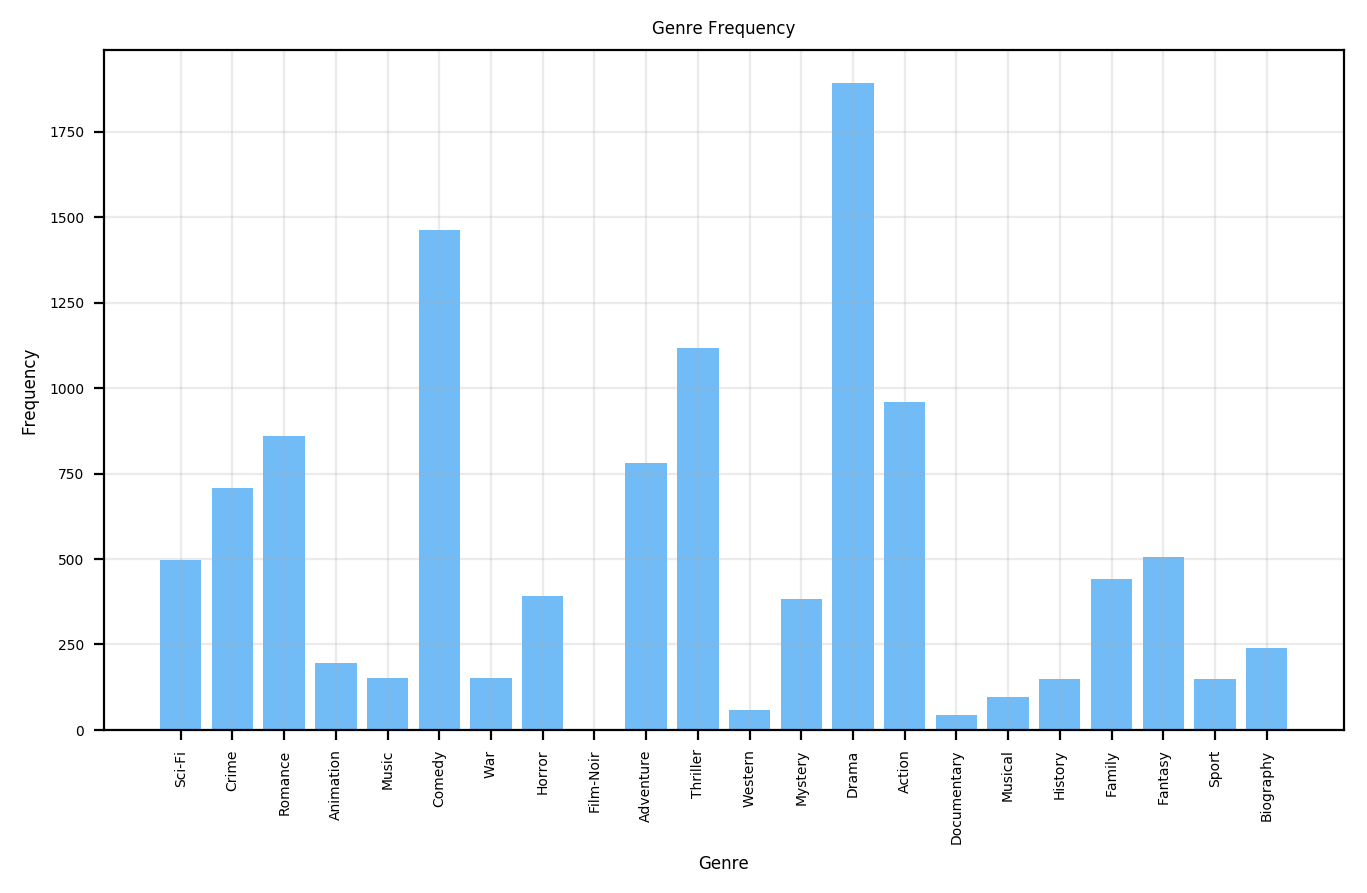

In [64]:
# print bar plot of the genre frequency
plt.subplots(figsize=(8, 4.5), dpi=200)
plt.bar(range(len(counts)), counts.values(), alpha = 0.75, color='#42A5F5', align='center')
plt.xlabel('Genre', fontsize = 6)
plt.ylabel('Frequency', fontsize =6)
plt.title('Genre Frequency', fontsize = 6)
plt.xticks(range(len(counts)), counts.keys(), rotation = 'vertical', fontsize = 5)
plt.yticks(fontsize = 5)
plt.grid(alpha =0.25)
plt.show()

The visualization above demonstrates how the most common movies are as expected - comedy, drama, action, thriller, and romance. The least common genres, meanwhile, include documentaries, Western movies, and Film-Noir. 

In [65]:
imdb_genres = np.unique(np.concatenate([x.split('|') for x in np.unique(imdb_df['genres'])]))[::-1]

# Get average rating by genre
rating_by_genre = np.zeros(imdb_genres.shape[0])
budget_by_genre = np.zeros(imdb_genres.shape[0])
duration_by_genre = np.zeros(imdb_genres.shape[0])

genre_count = np.zeros(imdb_genres.shape[0])

for _, row in imdb_df.iterrows():
    for genre in row['genres'].split('|'):
        genre_id = np.where(imdb_genres == genre)[0][0]
        rating_by_genre[genre_id] += row['imdb_score']
        budget_by_genre[genre_id] += (row['budget'] / 1000000)
        duration_by_genre[genre_id] += row['duration']
        genre_count[genre_id] += 1
        
rating_by_genre /= genre_count
budget_by_genre /= genre_count
duration_by_genre /= genre_count
genre_ids = range(len(imdb_genres))

In [66]:
# Function for plotting horizontal genre bar plots
def genre_barh(data, xlabel, title):
    plt.subplots(figsize=(8, 4.5), dpi=200)
    plt.barh(genre_ids, data, alpha=0.75, color='#42A5F5')
    plt.xlabel(xlabel, fontsize=6); plt.ylabel('Genre', fontsize=6)
    plt.title(title, fontsize=6)
    plt.yticks(genre_ids, imdb_genres, fontsize=6); 
    plt.xticks(fontsize=6); plt.grid(alpha=0.25); plt.show()

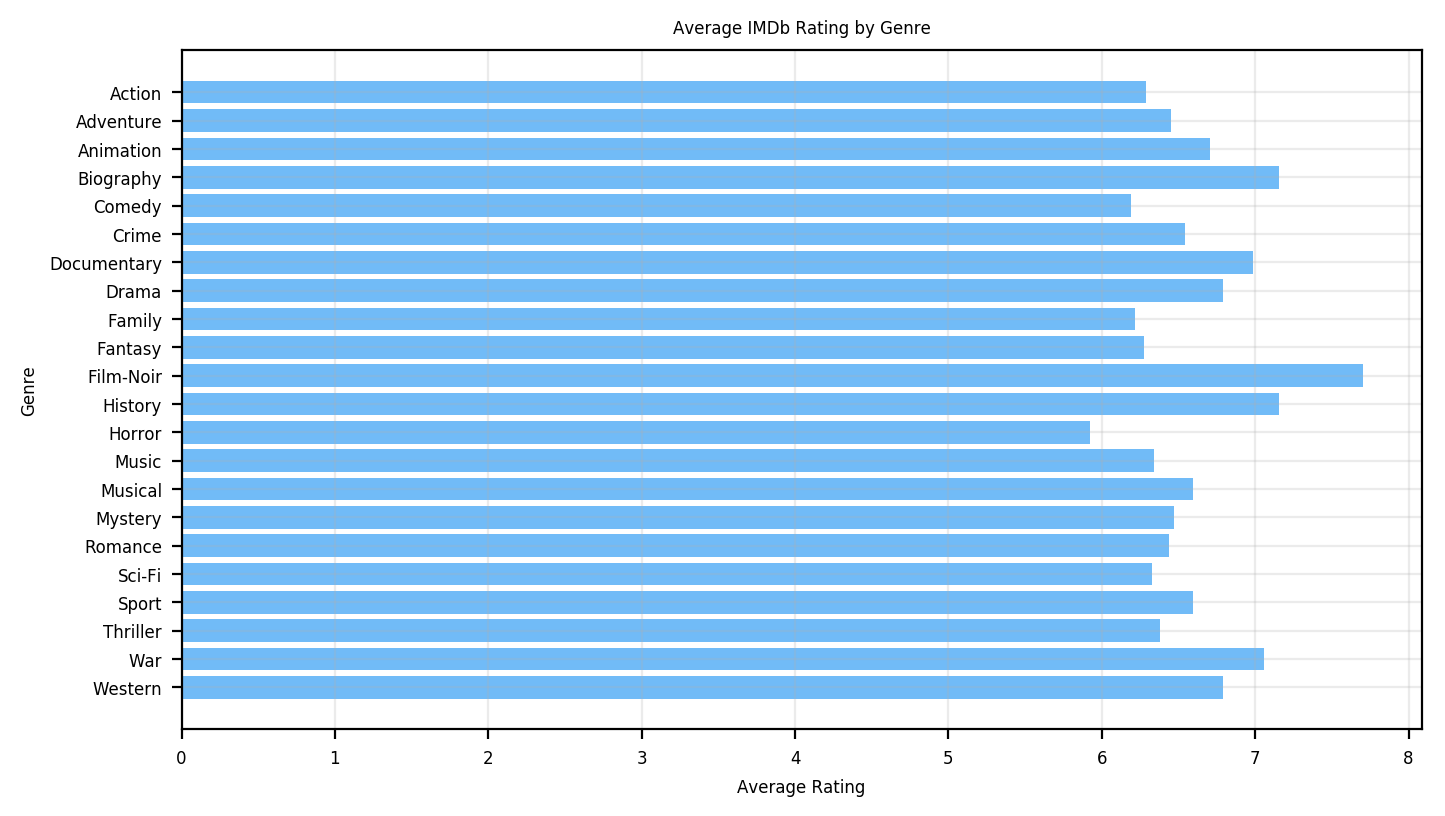

In [67]:
genre_barh(rating_by_genre, 'Average Rating', 'Average IMDb Rating by Genre')

Interestingly, all the ratings are quite similar, tending between 6 and 7. Some of the genres with the highest ratings are actually the genres with the lowest frequency (such as Film-Noir, Biography, War, and Western). However, this is not surprising since the smaller the sample size, the more skewed the results will be. 

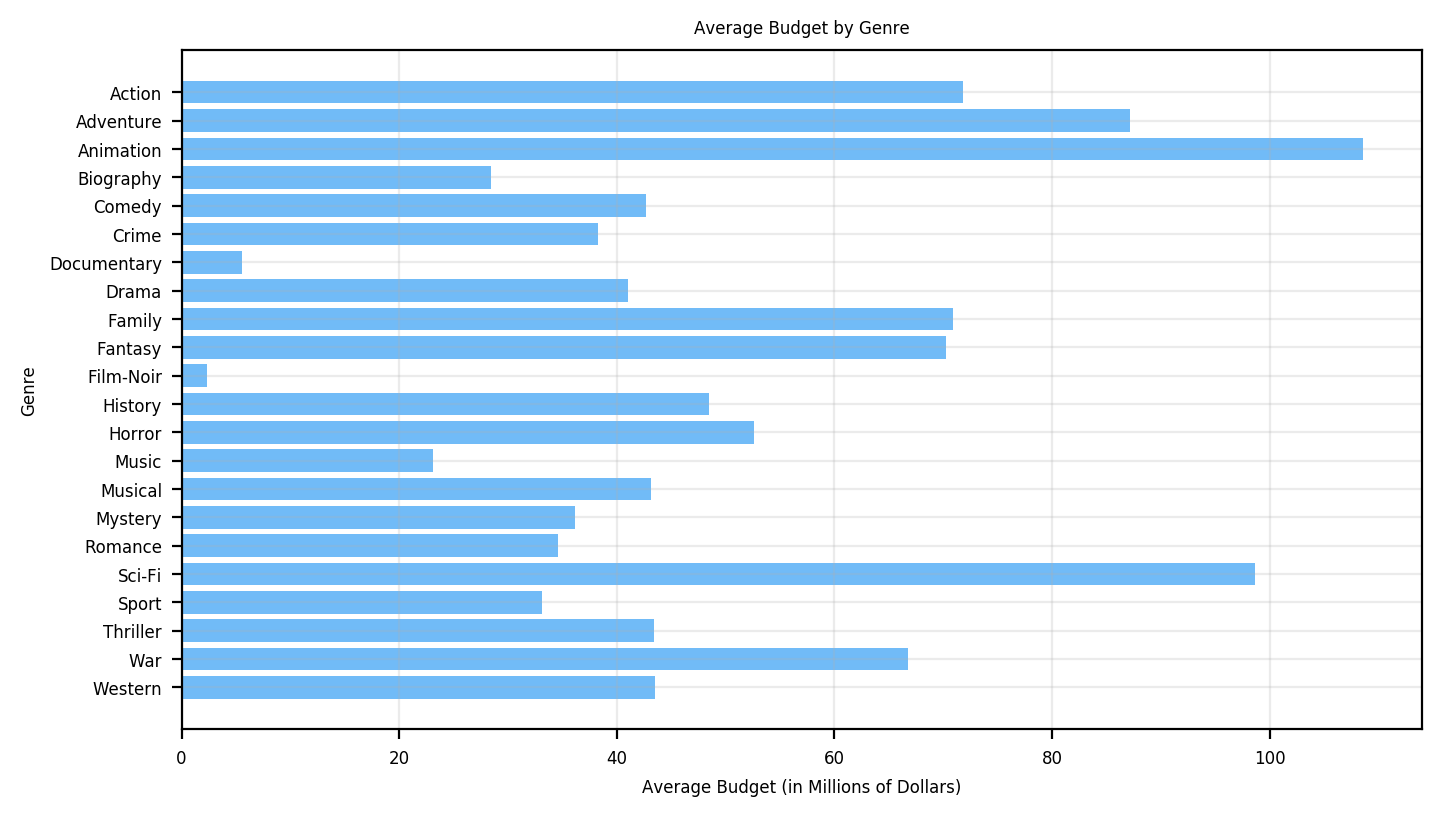

In [68]:
genre_barh(budget_by_genre, 'Average Budget (in Millions of Dollars)', 'Average Budget by Genre')

The movies that require the largest budgets are adventure, animation, action, and Sci-fi; these all heavily involve special effects, thus contributing to the large budget. Meanwhile documentaries and Film-Noir have especially low budgets, but this might again be because the small sample size skews the results of our budget analysis to one end of the curve.

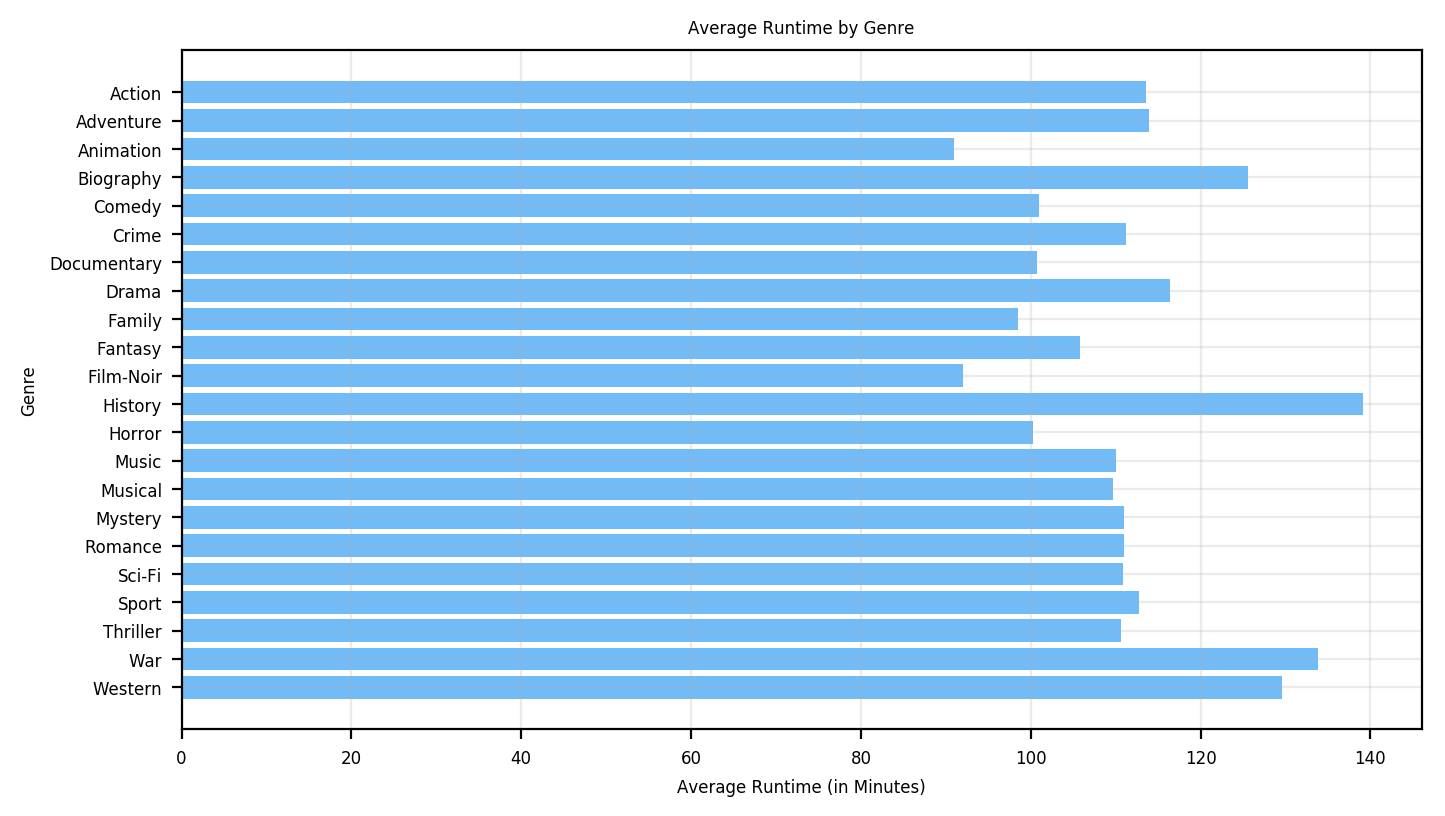

In [69]:
genre_barh(duration_by_genre, 'Average Runtime (in Minutes)', 'Average Runtime by Genre')

The average runtimes do not seem to tell us too much information; the genres that are most popular all seem to have similar runtimes, which likely indicates that movies in general have similar runtimes, and there is no one specific genre that runs shorter or longer. The extremities in the graph above (high average runtimes or low average runtimes) in general tend to be the genres with smaller sample sizes.

##### 7. A list of questions we could answer with this and related data.

1) How has the popularity of movies changed over time?

2) Have movies in certain languages come into style?

3) Which movies are popular in different places in the world (may need related data)?

4) What are the first movies people watch in a country that is developing?

5) What are the first genres people watch in a country that is developing?

6) How did the rise of internet streaming services (like Netflix) affect the popularity of different types of movies?